# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: 50
* Students: Görkem Çamli, Raphael Laporte, Ilija Gjorgjiev, Murat Genc
* Dataset: Spammers on Social Network

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import linalg

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency = sp.load("undirected_adjacency.npy")
adjacency = sparse.csr_matrix(adjacency,adjacency.shape,dtype=np.float16)
n_nodes =  adjacency.shape[0]

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
def compute_laplacian_normalized(L, degrees):
    newD =  sparse.spdiags(1/np.sqrt(degrees),[0],degrees.size,degrees.size)
    return ((newD @ L) @ newD)

In [5]:
degrees = adjacency.sum(0)
degree_matrix = sparse.spdiags(degrees,[0],n_nodes,n_nodes)
degree_matrix = sparse.csr_matrix(degree_matrix,degree_matrix.shape,dtype=np.float16)

In [6]:
#Laplacian Combinatorial
laplacian_combinatorial  =  degree_matrix - adjacency

In [7]:
#Laplacian Normalized
laplacian_normalized = compute_laplacian_normalized(laplacian_combinatorial, degrees)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

### Question 2

Compute the eigendecomposition of the Laplacian $L = U \Lambda U^\top$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [8]:
eigenvalues_c, eigenvectors_c = sparse.linalg.eigsh(laplacian_combinatorial,k=1000,which='SM',tol=0.001)
np.save("eigenvectors_combinatorial",eigenvectors_c)
np.save("eigenvalues_combinatorial",eigenvalues_c)
eigenvalues_n, eigenvectors_n = sparse.linalg.eigsh(laplacian_normalized,k=1000,which='SM',tol=0.001)
np.save("eigenvectors_normalized",eigenvectors_n)
np.save("eigenvalues_normalized" ,eigenvalues_n)

In [9]:
eigenvectors_c = np.load("eigenvectors_combinatorial.npy")
eigenvalues_c= np.load("eigenvalues_combinatorial.npy")

eigenvectors_n = np.load("eigenvectors_normalized.npy")
eigenvalues_n = np.load("eigenvalues_normalized.npy")

**Your answer here.**

As mentioned above in the comment, we decided to compute only 1000 eigenvalues and eigenvectors as our matrix is too big. We used a tolerance level of 0.001, because it was faster to compute. We would have originaly used the function mentioned in the above comments scipy.linalg.eigh(laplacian.toarray()), as it would have returned us the eigenvalues in asceding order and all of them, also our matrix is real symmetric(hermitian). Otherwise we decided to go with eigsh as it allows us to specify how many eigenvalues and eigenvectors we want and in what order(in our case we use which="SM"). The eigsh can be executed also since our matrix is hermitian and sparse.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

Matrix $S$ is the transpose of the incidence matrix. It has a shape of ($|V|$, $|E|$) , where $|E|$ is the number of edges(i, j) with i being the start node and j being the end node.  $|V|$ is the number of vertices in the graph. S consits of values of $0$, $1$, $-1$ as the incidence matrix. The values are filled based on the following conditions for the row[i] in S.
1. If e(i,j) exists in the graph then S[i][j] = 1, which means that there is an edge coming from i to j.
2. If e(j,i) exists in the graph then S[i][j] = -1, which means that there is an edge coming from j to i.
3. if e(i,j) and e(j,i) does not exist than S[i][j] = 0. 
Basically each ith row shows if there is an outgoing(1) or incoming(-1) edge for the ith node.

Whereas S^T is the incidence matrix. Also L does not depend on edge direction.

$S^T x$ computes and returns a vector which will contain for example for edge(i,j) where $i = 1$ and $j = -1$ in the $S^T$ matrix multiplying this will x will just result in x[i] - x[j], if the matrix is just adjacency and there are no weights. So we are going to have a vector which contains differences of ith element of x and jth element of x, for each row in the $S^T$ matrix. If we are dealing of a matrix, where the edges have weights than each element of $S^T x$ will be equal to (w[i] * x[i]) - (w[j] * x[j]), where i and j represent the direction of the node for a specific row of $S^T$.

In basic words $S^T x$ vector as a gradient.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

The following statements are equivalent:

$\lambda_k  u_{k} = L  u_k$   
$\lambda_k  u_{k} = S  S^{T}  u_k$   
$u_k^{T}  \lambda_k  u_{k} = u_k^{T}  S  S^{T}  u_{k}$   
$u_k^{T}  \lambda_k  u_{k} = (S^T  u_k)^T  S^T  u_k$  (by property: $(AB)^T = B^T  A^T$)    
$u_k^{T}  \lambda_k  u_{k} = ||S^T u_k||_2^2$  (by dot product which is the same as squared $L^2$ norm)   
$\lambda_k  u_{T}  u_{k} = ||S^T u_k||_2^2$   
$\lambda_k  ||u_k||_2^2 = ||S^T u_k||_2^2 $  
$\lambda_k   = \frac{||S^T u_k||_2^2}{||u_k||_2^2} $  
$\lambda_k = || S^T \frac{u_k}{||u_k||_2^2}||_2^2$  
$\lambda_k = \| S^\top u_k \|_2^2$

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

As mentioned above that $S^T x$ works as a gradient, then the squared $L^2$ norm would give us the smoothnes of x with respect to the graph.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

The following statements are equivalent:

$\lambda_0  u_{0} = L  u_0$   
$u_{0}^T \lambda_0  u_{0} = u_{0}^T L u_0$   
$ 0 = u_{0}^T L u_0$ (by property that $\lambda_0 = 0$)   
$ 0 =  \frac{1}{2} \sum_{i,j} W(i,j) (u_0[i] - u_0[j])^2$ (by property $x^T L x = \frac{1}{2} \sum_{i,j} W(i,j) (x[i] - x[j])^2$)  

This is only equal to 0, if and only if the non trivial values of $u_0$ are constant. So the elements of $u_0$ are all equal to one another.

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

In [10]:
eigenvalues = eigenvalues_n

In [11]:
# plot eigenvalues
def plotEigenvalues(eigenvalues):
  plt.scatter(x=range(len(eigenvalues)), y=eigenvalues )
  plt.title("Eigenvalue Plot")
  plt.xlabel("Eigenvalue Index")
  plt.ylabel("Eigenvalue")

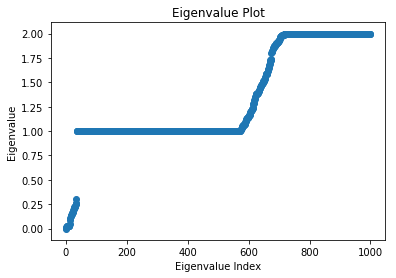

In [12]:
# Combinatorial Laplacian Eigenvalues Plot
plotEigenvalues(eigenvalues_c)

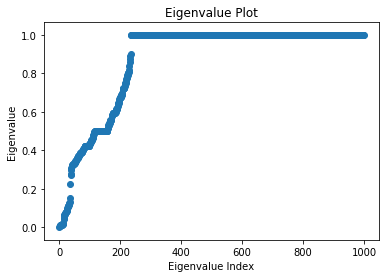

In [13]:
# Normalized Laplacian Eigenvalues Plot
plotEigenvalues(eigenvalues_n)

Scipy library returns the eigenvalues, each repeated according to its multiplicity. Therefore, from the above plot we can observe the spectrum of Laplacian (plotting the repeated eigenvalues according to its algebraic multiplicities).    We only plotted the first 1000 eigenvalues due to the computation time and memory constraints since our graph is too big.

**Combinatorial eigenvalue plot:**
We see that our first 1000 smallest eigenvalues ranges from 0 to 2. Overall, we see an increasing trend on the eigenvalue plot, more precisely, after ~0.30 eigenvalue it jumps to 1 eigenvalue continues stable for a while (values ar every close to each other) then has a huge increase  up to ~2 in 550-700ish indices and stabilizes again.

**Normalized eigenvalue plot:**
In the normalized laplacian eigenvalue results, we see an increasing trend up to around ~250 indices and then the values continue with value almost 1 afterwards. 

How many connected components are there in your graph? Answer using the eigenvalues only.

In [14]:
# print('Count of zeros: ', len(np.where(eigenvalues_c == 0)[0]))
# print('Count of zeros: ', len(np.where(eigenvalues_n == 0)[0]))

print('Count of zeros for Combinatorial: ', len(np.where(eigenvalues_c < 0.00001)[0]))
print('Count of zeros for Normalized: ', len(np.where(eigenvalues_n < 0.00001)[0]))

Count of zeros for Combinatorial:  1
Count of zeros for Normalized:  1


**Our answer:** When the graph is undirected and has non-negative weight, the multiplicity k of the eigenvalue 0 of L gives the number of connected components within the graph. Our graph also undirected and has non-negative weight therefore we can check the connected component number using this rule. The number of eigenvalue 0, is the number of connected components in our graph in this case our graph is connected and we have 1 component in our graph.  

Note that since our graph is very big and it takes a lot of time to compute the eigenvalues we pass a tolerant argument while calculating in the linalg.sparse.eigsh function, machine precision took very long time. In the above result, that is why we checked the values close to zero under certain threshold.

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

Yes, there is an upper bound on the eigenvalues. .

__Combinatorial Laplacian:__ The largest possible eigenvalue is the maximum degree (max row/col sum) of the laplacian matrix.      

__Normalize Laplacian:__ The upper bound for the largest eigenvalue is 2, the largest eigenvalue is 2 if and only if the graph is bipartite.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

From now on, if your graph has more than one connected component, work with the giant component only.

In [15]:
# Since we have 1 component we skip this part

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

We use Laplacian eigenmaps for non-linear dimensionality reduction and data visualization/representation purposes. Specifically, the assumption behind the laplacian eigenmaps is the data points lie in a lower dimensional manifold within a high-dimensional space. Since the Laplaican Eigenmap algorithm is rather insensitive to outliers and noise, it leads a natural implicit way for clustering, that is why it is also used in embeddings and clustering. Therefore, Laplacian Eigenmaps are useful for visualizing a graph, spectral clustering and partitioning and also graph coloring. Computer vision and learning is some of the areas they are used at. 
 
More generally, graph embeddings are used for again finding the latent vector representations of the graphs in order to capture topology of the graph and used commonly in machine learning. Their main purpose is to preserve some proximity measure defined on the graph by creating mappings.

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [16]:
d = 2
# We recompute the eigenvectors since it is asked - althought we could have used the prvios ones
# eigenval_c, eigenvec_c = sparse.linalg.eigsh(laplacian_combinatorial,k=d+1,which='SM')
# eigenval_n, eigenvec_n = sparse.linalg.eigsh(laplacian_normalized,k=d+1,which='SM')

In [17]:
# take the first d dimensions excluding
laplacian_embedded = eigenvectors_c[:,1:d+1]
laplacian_embedded_normalize = eigenvectors_n[:,1:d+1]
laplacian_embedded.shape

(62173, 2)

Plot the nodes embedded in 2D. Comment on what you see.

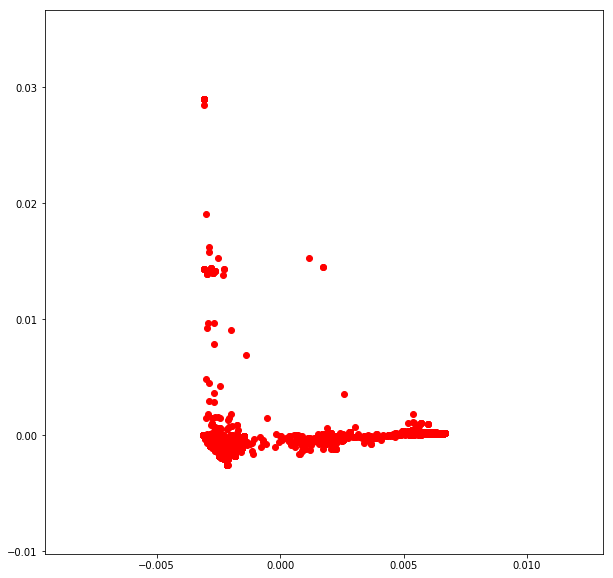

In [18]:
# plotting embedded graph in 2D for Combinatorial
fig = plt.figure(figsize=(10, 10))
ax = plt.scatter(laplacian_embedded[:, 0], laplacian_embedded[:, 1],c=['red'],cmap=plt.cm.Spectral)

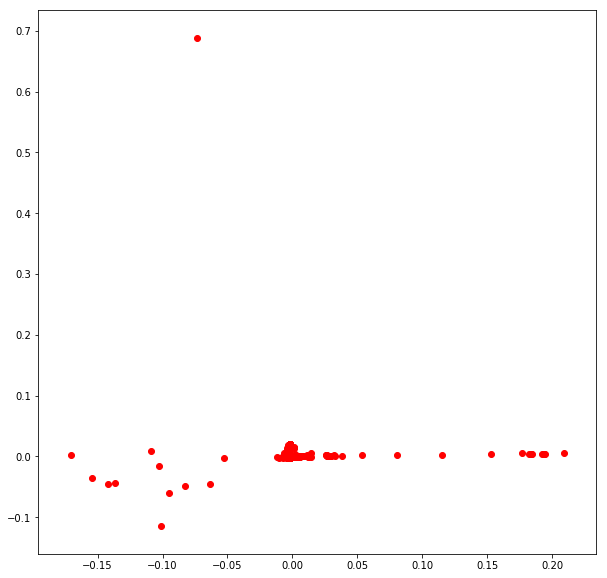

In [19]:
# plotting embedded graph in 2D for Normalized
fig = plt.figure(figsize=(10, 10))
ax = plt.scatter(laplacian_embedded_normalize[:, 0], laplacian_embedded_normalize[:, 1],c=['red'],cmap=plt.cm.Spectral)

For the Combinatorial laplacian 2D plot result what we see is that we see a main location where the points are mostly gathered and two branches one with higher intensity and close to each other and the other more dispersed and a few more outlier points. For the normalized laplacian 2D embedded plot , we see that the points are more normalized and closer to each other and now dispersed through mostly in x direction and the projected points looks like dispersed through a line. 

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

The idea for the Laplacian Eigenmap embedding is to keep connected nodes closer to each other in the vector space. Embedding Z preserves the local neighborhood information embedded for N data in a lower dimensional space in this case for d dimension. These information found by using nearest neighboor calculations for laplacian eigenmaps.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

*In theory, we interpret the value of k by analyzing Laplacian spectrum. If the spectrum clearly has n different clusters, then n=k. For our spectrum, we'll choose k=2 as can be interpreted from Laplacian spectrum. "d" refers to dimension, and we'll choose d=3 for visualisation.*

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [20]:
eigenvectors = eigenvectors_n

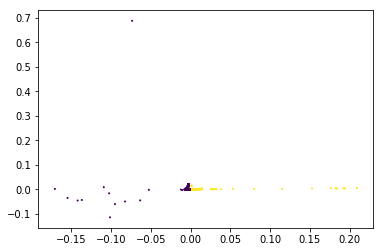

In [21]:
#eigenvector normalization
from sklearn import preprocessing

k=2
d=k+1

r = eigenvectors[:,1:d]

thresh                     = 0
y_kmeans                   = np.copy(eigenvectors[:,1])
y_kmeans[y_kmeans> thresh] = 1
y_kmeans[y_kmeans<=thresh] = 0

#color the graph
plt.scatter(r[:, 0], r[:, 1], c=y_kmeans, s=1, cmap='viridis')

# We prefer keeping the re-normalized eigenvectors as the graph has k=2 clear clusters.

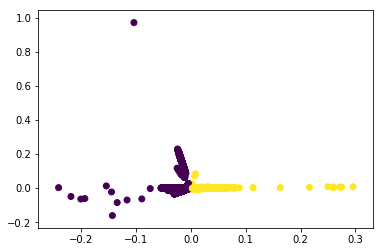

In [22]:
#visualize laplacian spectrum with normalized eigenvector v_normalized

r2     = preprocessing.normalize(eigenvectors, norm='l2')[:,1:d]

y_kmeans                   = np.copy(r2[:,0])
y_kmeans[y_kmeans> thresh] = 1
y_kmeans[y_kmeans<=thresh] = 0


#color the graph
plt.scatter(r2[:,0], r2[:,1], c=y_kmeans, cmap='viridis')

*We prefer keeping the re-normalized eigenvectors as the graph has less outliers.*

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

Since our adjacency matrix is undirected, we were expecting to observe cliques

In [23]:
x_idx, x = zip(*sorted(zip(y_kmeans,range(len(y_kmeans)))))
y_idx, y = zip(*sorted(zip(y_kmeans,range(len(y_kmeans)))))

adjacency_ordered = adjacency[x,:][:,y]

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [24]:
import pandas as pd
users        = pd.read_csv('data/filtered_users.csv')
ground_truth = np.array(users[["Spammer Label"]])

n_nodes = len(ground_truth)
# We assign our spammers / non-spammers clusters according to what gives us the best succes rate
error_rate   = np.average((y_kmeans - ground_truth.reshape((n_nodes,)))**2)
success_rate = error_rate if error_rate > 0.5 else 1-error_rate 
print("Our success ratio is : ",success_rate)

Our success ratio is :  0.7024110144274847


### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

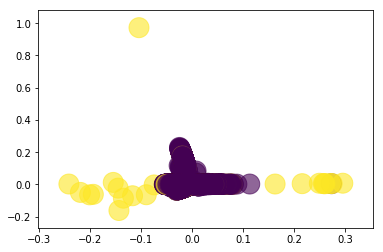

In [25]:
plt.scatter(r2[:,0], r2[:,1], c=ground_truth.reshape((n_nodes,)), s=400, cmap='viridis', alpha = 0.6)

When looking at our ground truth, we see that our clustering is not that far off from the ground truth.    
Interestingly, our miss-assigned points are all in one area ( to the right of the purple cluster, we have a bunch of yellow data points that should be in the purple cluster )
We think that these miss-assigned points correspond to users who are especially targeted by spammers -- our analysis used the undirected adjacency matrix, and as such, nodes corresponding to users being spammed could be topologically similar to those corresponding to spammers. 

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

The eigenvectors of the graph Laplacian preserve local distances, and as such are relatively insensitive to ouliers and noise^1. Dimensionality reduction is necessary for clustering as we are initially running in a space with too many dimensions for k_means to converge -- as such, using eigenvectors as features is recommended as they allow us to reduce dimensions whilst minimizing entropy loss. However, this does not necessarily mean that we must use the eigenvectors from the graph Laplacian, using eigenvectors extracted from other features can also work.